# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

In [4]:
!pip install optuna
!pip install lightgbm

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import lightgbm as lgb
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

### Загрузим данные и выполним их ресемплирование по одному часу

In [7]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1h').sum()
display(data.head())
display(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

Датасет содержит 4416 значений с марта по август включительно 2018 года.

## Анализ данных

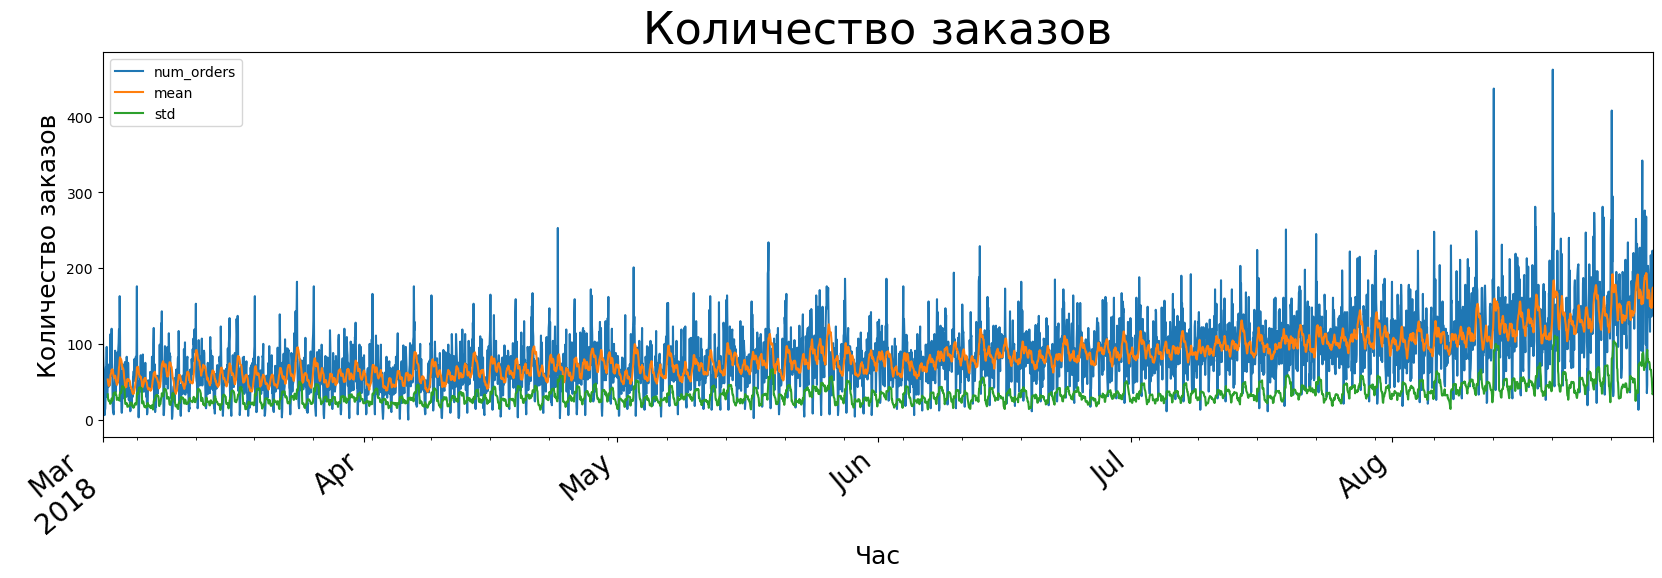

In [10]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot(figsize=(20, 5))
plt.title('Количество заказов', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');

Из графика можно сделать вывод, что временной ряд на анализируемом периоде не стационарный, потому что среднее значение и стандартное отклонение изменяются со временем. Однако, возможно из-за того, что данные представлены всего за полгода, это не восходящий тренд, а сезонная составляющая временного ряда.

In [12]:
data = data.drop(['mean', 'std'], axis=1)

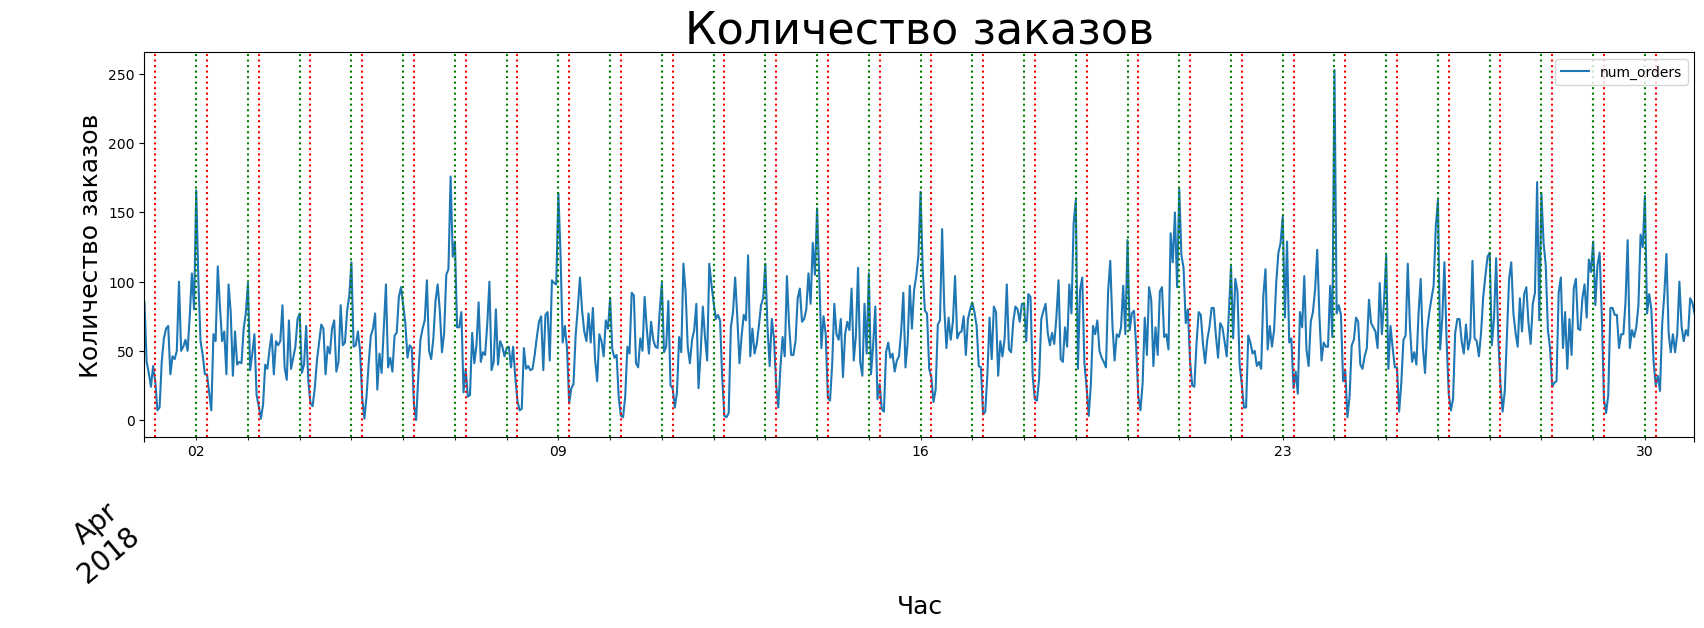

In [13]:
data['2018-04-01':'2018-04-30'].plot(figsize=(20, 5))
for i in data['2018-04-01':'2018-04-30'].index:
    if i.hour == 0:
        plt.axvline(x=i, color='green', linestyle=':')
    if i.hour == 5:
        plt.axvline(x=i, color='red', linestyle=':')
plt.title('Количество заказов', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');

При рассмотрении временного ряда в масштабе одного месяца, можно заметить сезонность, кратную одному дню. Максимум заказов приходится на полночь, а минимально количество заказов в 5 утра каждого дня.

## Обучение моделей

Создадим функцию для генерации новых признаков

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    # Функция для создания новых признаков
    ret_df = data.copy()
    ret_df['day'] = ret_df.index.day
    ret_df['dayofweek'] = ret_df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)

    ret_df['rolling_mean'] = ret_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return ret_df

Для перебора гиперпараметров будем использовать `Optuna`

In [19]:
def objective(trial):
    # Гиперпараметры для настройки
    max_lag = trial.suggest_int('max_lag', 1, 200)
    rolling_mean_size = trial.suggest_int('rolling_mean_size', 1, 200)
    model_name = trial.suggest_categorical("regressor", ["LGBMRegressor", "LinearRegression"])
    
    if model_name == "LGBMRegressor":
        num_leaves = trial.suggest_categorical("num_leaves", [2, 4, 8])
        model = lgb.LGBMRegressor(num_leaves=num_leaves)
    else:
        model = LinearRegression()
    
    df = make_features(data, max_lag, rolling_mean_size)
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train = train.dropna()
    test = test.dropna()

    y_train = train['num_orders']
    X_train = train.drop('num_orders', axis=1)
    y_test = test['num_orders']
    X_test = test.drop('num_orders', axis=1)
    
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    
    return root_mean_squared_error(y_test_pred, y_test)

In [20]:
sampler = TPESampler(seed=25)
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=20);

[I 2024-10-09 02:07:27,109] A new study created in memory with name: no-name-7697af1b-d3d2-42db-abba-9cdbed84394e
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\104010

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32759
[LightGBM] [Info] Number of data points in the train set: 3799, number of used features: 178
[LightGBM] [Info] Start training from score 79.386944
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4632
[LightGBM] [Info] Number of data points in the train set: 3884, number of used features: 26
[LightGBM] [Info] Start training from score 78.852987


[I 2024-10-09 02:07:27,549] Trial 3 finished with value: 40.934101812134 and parameters: {'max_lag': 74, 'rolling_mean_size': 168, 'regressor': 'LinearRegression'}. Best is trial 0 with value: 37.433081067713275.
[I 2024-10-09 02:07:27,603] Trial 4 finished with value: 40.75403100811848 and parameters: {'max_lag': 77, 'rolling_mean_size': 200, 'regressor': 'LinearRegression'}. Best is trial 0 with value: 37.433081067713275.
[I 2024-10-09 02:07:27,614] Trial 5 finished with value: 49.89035279438498 and parameters: {'max_lag': 7, 'rolling_mean_size': 144, 'regressor': 'LinearRegression'}. Best is trial 0 with value: 37.433081067713275.
[I 2024-10-09 02:07:27,703] Trial 6 finished with value: 40.594450352457166 and parameters: {'max_lag': 57, 'rolling_mean_size': 181, 'regressor': 'LGBMRegressor', 'num_leaves': 8}. Best is trial 0 with value: 37.433081067713275.
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11024
[LightGBM] [Info] Number of data points in the train set: 3793, number of used features: 60
[LightGBM] [Info] Start training from score 79.409966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28178
[LightGBM] [Info] Number of data points in the train set: 3808, number of used features: 153
[LightGBM] [Info] Start training from score 79.369223


[I 2024-10-09 02:07:27,856] Trial 7 finished with value: 43.27060928799409 and parameters: {'max_lag': 150, 'rolling_mean_size': 166, 'regressor': 'LGBMRegressor', 'num_leaves': 2}. Best is trial 0 with value: 37.433081067713275.
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df[

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36945
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 201
[LightGBM] [Info] Start training from score 79.480138


C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36945
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 201
[LightGBM] [Info] Start training from score 79.480138


C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36399
[LightGBM] [Info] Number of data points in the train set: 3779, number of used features: 198
[LightGBM] [Info] Start training from score 79.433448


C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30573
[LightGBM] [Info] Number of data points in the train set: 3811, number of used features: 166
[LightGBM] [Info] Start training from score 79.368145


C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33123
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 180
[LightGBM] [Info] Start training from score 79.403476


C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36945
[LightGBM] [Info] Number of data points in the train set: 3776, number of used features: 201
[LightGBM] [Info] Start training from score 79.480138


In [21]:
print("Лучшая метрика:", study.best_value)
print("Лучшие гиперпараметры:", study.best_params)

Лучшая метрика: 34.15510403487075
Лучшие гиперпараметры: {'max_lag': 192, 'rolling_mean_size': 177, 'regressor': 'LinearRegression'}


Построим график реального и предсказанного значения:

In [23]:
df = make_features(data, study.best_trial.params['max_lag'], study.best_trial.params['rolling_mean_size'])
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
test = test.dropna()

y_train = train['num_orders']
X_train = train.drop('num_orders', axis=1)
y_test = test['num_orders']
X_test = test.drop('num_orders', axis=1)
model = LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
plt_df = pd.DataFrame(y_test)
plt_df['prediciton'] = y_test_pred

C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['lag_{}'.format(lag)] = ret_df['num_orders'].shift(lag)
C:\Users\Zhenya-PC\AppData\Local\Temp\ipykernel_12660\1040109239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

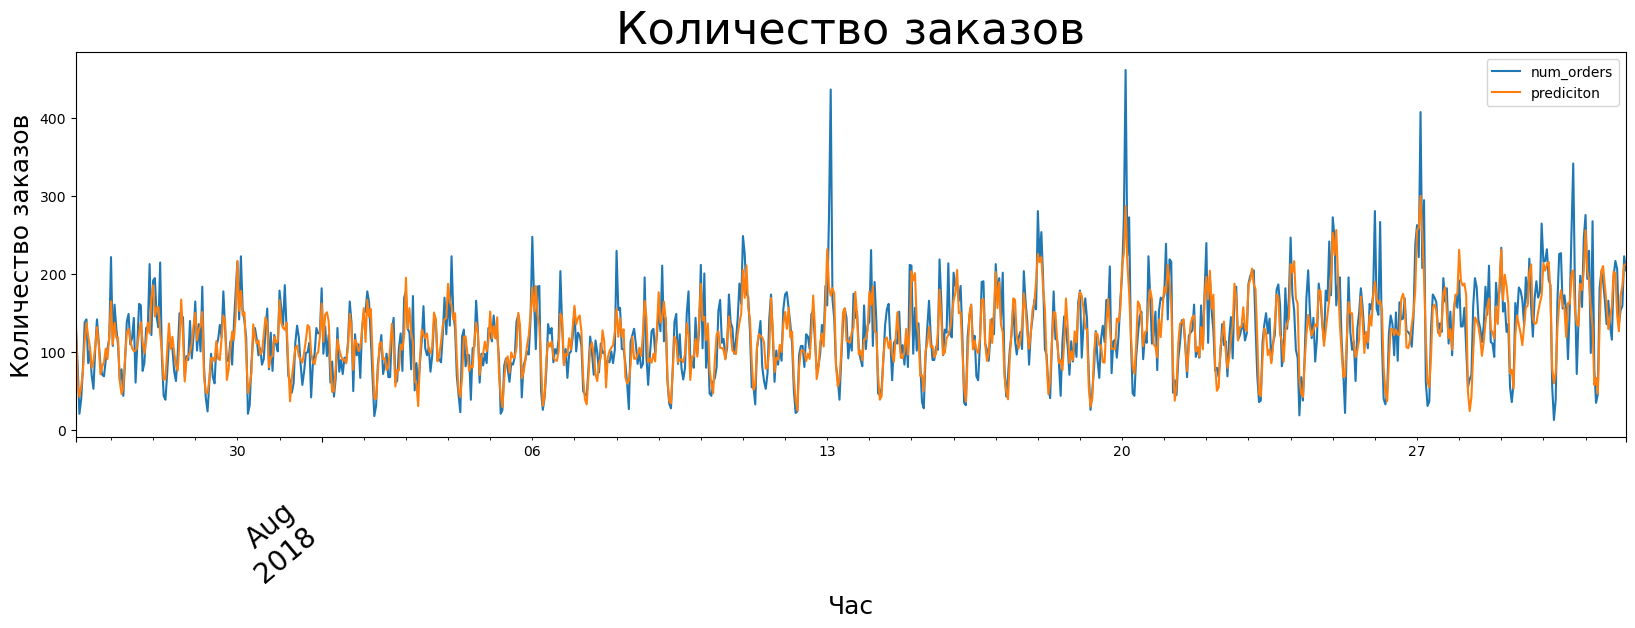

In [24]:
plt_df.plot(figsize=(20, 5))
plt.title('Количество заказов', fontsize=32)
plt.xlabel('Час', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.xticks(fontsize=20, rotation=40, horizontalalignment='right');

Проведем тест на адекватность. Посчитаем метрику в случае если бы наша модель всегда предсказывала среднее значение:

In [26]:
y_test_median = np.ones(y_test.shape) * y_train.median()
print("RMSE:", root_mean_squared_error(y_test_median, y_test))

RMSE: 75.31404086311677


Метрика значительно хуже

## Вывод
В ходе работы был выгружен датасет с историческими данными о заказах такси в аэропортах с десятиминутным интервалом. Датасет был ресемплирован в часовые интервалы и произведен анализ данных. В ходе анализа было обнаружено, что временной ряд на анализируемом периоде не стационарный, потому что среднее значение и стандартное отклонение изменяются со временем. Временной ряд обладает восходящим трендом. Однако, возможно это из-за того, что данные представлены всего за полгода и это не восходящий тренд, а сезонная составляющая временного ряда. Помимо этого, при рассмотрении данных в масштабах месяца, было обнаружено, что в данных содержится периодичность, кратная суткам. Максимальное количество заказов приходится на полночь, а минимальное на 5 часов утра. После анализа, были обучены две модели `LGBMRegressor` и `LinearRegression` с перобором гиперпараметров с помощью инструмента `Optuna`. Лучшую метрику показала модель `LinearRegression`. Завершаюшим шагом работы была проверка тестом на адекватность. Подсчет метрики, в случае если бы наша модель всегда предсказывала среднее значение, дал значительно худшие результаты, что говорит о целесообразности использования обученной в ходе работы модели.